In [2]:
import pandas as pd
import numpy as np
import re
import string
from underthesea import word_tokenize

In [3]:
from underthesea import ner

In [4]:
ner("chuẩn bị hàng lâu đồng hồ không kết nối được với ap như trong hướng dẫn nên không chỉnh được giờ mua về coi như bỏ")

[('chuẩn bị', 'V', 'B-VP', 'O'),
 ('hàng', 'N', 'B-NP', 'O'),
 ('lâu', 'A', 'B-AP', 'O'),
 ('đồng hồ', 'N', 'B-NP', 'O'),
 ('không', 'R', 'O', 'O'),
 ('kết nối', 'V', 'B-VP', 'O'),
 ('được', 'R', 'O', 'O'),
 ('với', 'E', 'B-PP', 'O'),
 ('ap', 'N', 'B-NP', 'O'),
 ('như', 'C', 'O', 'O'),
 ('trong', 'E', 'B-PP', 'O'),
 ('hướng dẫn', 'V', 'B-VP', 'O'),
 ('nên', 'C', 'O', 'O'),
 ('không', 'R', 'O', 'O'),
 ('chỉnh', 'V', 'B-VP', 'O'),
 ('được', 'V', 'B-VP', 'O'),
 ('giờ', 'N', 'B-NP', 'O'),
 ('mua', 'V', 'B-VP', 'O'),
 ('về', 'E', 'B-PP', 'O'),
 ('coi', 'V', 'B-VP', 'O'),
 ('như', 'C', 'O', 'O'),
 ('bỏ', 'V', 'B-VP', 'O')]

In [5]:
pd.options.display.max_columns = None

In [6]:
import wordcloud

# 1. Read file and cleaning 

In [7]:
def read_all_file_in_path(folder_path):
  import os

  # List all the Parquet files in the folder
  parquet_files = os.listdir(folder_path)

  # Create a list of DataFrames
  dataframes = []
  print("file in folder:")
  for parquet_file in parquet_files:
      # Read the Parquet file into a DataFrame
    print(parquet_file)
    if parquet_file == "train_4.csv":
      df = pd.read_csv(os.path.join(folder_path, parquet_file), encoding= "utf8")
      dataframes.append(df)
    elif parquet_file == "rating3.xlsx":
       continue
    else:
      df = pd.read_excel(os.path.join(folder_path, parquet_file))
      dataframes.append(df)

      # Add the DataFrame to the list of DataFrames
      
  df_combined = pd.concat(dataframes)
  df_combined = df_combined.reset_index()
  return df_combined

def expand_contractions(sentence, contraction_mapping):
  sentence = " " + sentence + " "
  contraction_pattern = re.compile("({})".format("|".join(contraction_mapping.keys())), flags= re.IGNORECASE|re.DOTALL)
  def expand_match(contraction):
    match = contraction.group(0)
    first_char = match[1]
    expanded_contraction = contraction_mapping.get(match) if contraction_mapping.get(match) else contraction_mapping.get(match.lower())
    expanded_contraction = " " + first_char + expanded_contraction[1:] + " "
    return expanded_contraction
  expanded_sentence = contraction_pattern.sub(expand_match, sentence)
  while sentence != expanded_sentence:
    sentence = expanded_sentence
    expanded_sentence = contraction_pattern.sub(expand_match, sentence)
    
  return expanded_sentence.strip()

def remove_all_tag(sentence):
   return re.sub(r'\n|\t|\r', ' ', sentence)

def remove_all_numbers(sentence):
   return re.sub(r'[0-9]', '', sentence)

def replace_sent(text, replace_list):
    for k, v in replace_list.items():
        text = text.replace(k, v)
    return text


In [8]:
def remove_repeated_characters(tokens): 
 repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)') 
 match_substitution = r'\1\2\3' 
 
 def replace(old_word):  
    new_word = repeat_pattern.sub(match_substitution, old_word) 
    return replace(new_word) if new_word != old_word else new_word 
 correct_tokens = [replace(word) for word in tokens] 
 return correct_tokens

def remove_character_before_tokenization(sentence, keep_apostrophes = False):
    sentence = sentence.strip()
    if keep_apostrophes:
        PATTERN = r"[?|$|&|*|%|@|(|)|~|.|,]"
        filtered_sentence = re.sub(PATTERN, r"", sentence)
    else:
        PATTERN = r"^a-zA-Z0-9"
        filtered_sentence = re.sub(PATTERN, r"", sentence)
    return filtered_sentence

def tokenize_text(text): 
 sentences = word_tokenize(text) 
 word_tokens = [word_tokenize(sentence) for sentence in sentences] 
 return word_tokens 

def remove_duplicate_ending_letters(word):
  pattern = r"\b(\w+)(.)\2{1}\b"
  replaced_word = re.sub(pattern, r"\1\2", word)
  while replaced_word != word:
    word = replaced_word
    pattern = r"\b(\w+)(.)\2{1}\b"
    replaced_word = re.sub(pattern, r"\1\2", replaced_word)
  return replaced_word

def remove_punctuation(text):
  return text.translate(str.maketrans({a:None for a in string.punctuation}))

In [9]:
VIET_TAT = {
    " sp " : "sản phẩm",
    " dc ": "được",
    " k ": "không",
    " ko ": "không",
    " r ": "rồi",
    " oke ": "ok",
    " okie ": "ok",
    " okey ": "ok",
    " nt ": "nhắn tin",
    " bt ": "biết",
    " bít ": "biết",
    
}

replace_list = {
        'òa': 'oà', 'óa': 'oá', 'ỏa': 'oả', 'õa': 'oã', 'ọa': 'oạ', 'òe': 'oè', 'óe': 'oé','ỏe': 'oẻ',
        'õe': 'oẽ', 'ọe': 'oẹ', 'ùy': 'uỳ', 'úy': 'uý', 'ủy': 'uỷ', 'ũy': 'uỹ','ụy': 'uỵ', 'uả': 'ủa',
        'ả': 'ả', 'ố': 'ố', 'u´': 'ố','ỗ': 'ỗ', 'ồ': 'ồ', 'ổ': 'ổ', 'ấ': 'ấ', 'ẫ': 'ẫ', 'ẩ': 'ẩ',
        'ầ': 'ầ', 'ỏ': 'ỏ', 'ề': 'ề','ễ': 'ễ', 'ắ': 'ắ', 'ủ': 'ủ', 'ế': 'ế', 'ở': 'ở', 'ỉ': 'ỉ',
        'ẻ': 'ẻ', 'àk': u' à ','aˋ': 'à', 'iˋ': 'ì', 'ă´': 'ắ','ử': 'ử', 'e˜': 'ẽ', 'y˜': 'ỹ', 'a´': 'á',
        #Quy các icon về 2 loại emoj: Tích cực hoặc tiêu cực
        "👹": "negative", "👻": "positive", "💃": "positive",'🤙': ' positive ', '👍': ' positive ',
        "💄": "positive", "💎": "positive", "💩": "positive","😕": "negative", "😱": "negative", "😸": "positive",
        "😾": "negative", "🚫": "negative",  "🤬": "negative","🧚": "positive", "🧡": "positive",'🐶':' positive ',
        '👎': ' negative ', '😣': ' negative ','✨': ' positive ', '❣': ' positive ','☀': ' positive ',
        '♥': ' positive ', '🤩': ' positive ', 'like': ' positive ', '💌': ' positive ',
        '🤣': ' positive ', '🖤': ' positive ', '🤤': ' positive ', ':(': ' negative ', '😢': ' negative ',
        '❤': ' positive ', '😍': ' positive ', '😘': ' positive ', '😪': ' negative ', '😊': ' positive ',
        '?': ' ? ', '😁': ' positive ', '💖': ' positive ', '😟': ' negative ', '😭': ' negative ',
        '💯': ' positive ', '💗': ' positive ', '♡': ' positive ', '💜': ' positive ', '🤗': ' positive ',
        '^^': ' positive ', '😨': ' negative ', '☺': ' positive ', '💋': ' positive ', '👌': ' positive ',
        '😖': ' negative ', '😀': ' positive ', ':((': ' negative ', '😡': ' negative ', '😠': ' negative ',
        '😒': ' negative ', '🙂': ' positive ', '😏': ' negative ', '😝': ' positive ', '😄': ' positive ',
        '😙': ' positive ', '😤': ' negative ', '😎': ' positive ', '😆': ' positive ', '💚': ' positive ',
        '✌': ' positive ', '💕': ' positive ', '😞': ' negative ', '😓': ' negative ', '️🆗️': ' positive ',
        '😉': ' positive ', '😂': ' positive ', ':v': '  positive ', '=))': '  positive ', '😋': ' positive ', "🙆": ' positive ', "🤍": ' positive ', "🥰": ' positive ',
        '💓': ' positive ', '😐': ' negative ', ':3': ' positive ', '😫': ' negative ', '😥': ' negative ', '😅': ' positive ',
        '😃': ' positive ', '😬': ' 😬 ', '😌': ' 😌 ', '💛': ' positive ', '🤝': ' positive ', '🎈': ' positive ',
        '😗': ' positive ', '🤔': ' negative ', '😑': ' negative ', '🔥': ' negative ', '🙏': ' negative ',
        '🆗': ' positive ', '😻': ' positive ', '💙': ' positive ', '💟': ' positive ',
        '😚': ' positive ', '❌': ' negative ', '👏': ' positive ', ';)': ' positive ', '<3': ' positive ',
        '🌝': ' positive ',  '🌷': ' positive ', '🌸': ' positive ', '🌺': ' positive ',
        '🌼': ' positive ', '🍓': ' positive ', '🐅': ' positive ', '🐾': ' positive ', '👉': ' positive ',
        '💐': ' positive ', '💞': ' positive ', '💥': ' positive ', '💪': ' positive ',
        '💰': ' positive ',  '😇': ' positive ', '😛': ' positive ', '😜': ' positive ',
        '🙃': ' positive ', '🤑': ' positive ', '🤪': ' positive ','☹': ' negative ',  '💀': ' negative ',
        '😔': ' negative ', '😧': ' negative ', '😩': ' negative ', '😰': ' negative ', '😳': ' negative ', "🥲": ' negative ', '🙄': ' negative ', '🤦': ' negative ',
        '😵': ' negative ', '😶': ' negative ', '🙁': ' negative ', "⏸": " product ", "★": ' star ', '♀': " ", '😅': " positive ", " 👋 ": " ", " 🏻 ": " product ", "🏿": " product ", "😽": " positve ",
        "😬" : ' negative ', '🤷': ' negative ', '😌': ' poisitive ', "😿": ' negative ', '✓': " positive ", '☆': ' star ', 'ಠ｣ಠ༎ຶ‿༎ຶ': ' ', '🐵': ' negative ', 
        "👂" : ' ', "😴": ' negative ', '👋': ' ', '\xa0': ' ', '🏻': ' product ', '🏻': ' product ',
        #Chuẩn hóa 1 số sentiment words/English words
        ':))': '  positive ', ':)': ' positive ', 'ô kêi': ' ok ', 'okie': ' ok ', ' o kê ': ' ok ', "cmn": "cm",
        'okey': ' ok ', 'ôkê': ' ok ', 'oki': ' ok ', ' oke ':  ' ok ',' okay':' ok ','okê':' ok ',
        ' tks ': u' cám ơn ', 'thks': u' cám ơn ', 'thanks': u' cám ơn ', 'ths': u' cám ơn ', 'thank': u' cám ơn ',
        '⭐': 'star ', '*': 'star ', '🌟': 'star ', '🎉': u' positive ', "bik": " bị ",
        'kg ': u' không ','not': u' không ', u' kg ': u' không ', '"k ': u' không ',' kh ':u' không ','kô':u' không ','hok':u' không ',' kp ': u' không phải ',u' kô ': u' không ', '"ko ': u' không ', u' ko ': u' không ', u' k ': u' không ', 'khong': u' không ', u' hok ': u' không ',
        'he he': ' positive ','hehe': ' positive ','hihi': ' positive ', 'haha': ' positive ', 'hjhj': ' positive ',
        ' lol ': ' negative ',' cc ': ' negative ','cute': u' dễ thương ','huhu': ' negative ', ' vs ': u' với ', 'wa': ' quá ', 'wá': u' quá', 'j': u' gì ', '“': ' ',
        ' sz ': u' cỡ ', 'size': u' cỡ ', u' đx ': u' được ', 'dk': u' được ', 'dc': u' được ', 'đk': u' được ',
        'đc': u' được ','authentic': u' chuẩn chính hãng ',u' aut ': u' chuẩn chính hãng ', u' auth ': u' chuẩn chính hãng ', 'thick': u' positive ', 'store': u' cửa hàng ',
        'shop': u' cửa hàng ', 'sp': u' sản phẩm ', 'gud': u' tốt ','god': u' tốt ','wel done':' tốt ', 'good': u' tốt ', 'gút': u' tốt ',
        'sấu': u' xấu ','gut': u' tốt ', u' tot ': u' tốt ', u' nice ': u' tốt ', 'perfect': 'rất tốt', 'bt': u' bình thường ',
        'time': u' thời gian ', 'qá': u' quá ', u' ship ': u' giao hàng ', u' m ': u' mình ', u' mik ': u' mình ',
        'ể': 'ể', 'product': 'sản phẩm', 'quality': 'chất lượng','chat':' chất ', 'excelent': 'hoàn hảo', 'bad': 'tệ','fresh': ' tươi ','sad': ' tệ ',
        'date': u' hạn sử dụng ', 'hsd': u' hạn sử dụng ','quickly': u' nhanh ', 'quick': u' nhanh ','fast': u' nhanh ','delivery': u' giao hàng ',u' síp ': u' giao hàng ',
        'beautiful': u' đẹp tuyệt vời ', u' tl ': u' trả lời ', u' r ': u' rồi ', u' shopE ': u' cửa hàng ',u' order ': u' đặt hàng ',
        'chất lg': u' chất lượng ',u' sd ': u' sử dụng ',u' dt ': u' điện thoại ',u' nt ': u' nhắn tin ',u' tl ': u' trả lời ',u' sài ': u' xài ',u'bjo':u' bao giờ ',
        'thik': u' thích ',u' sop ': u' cửa hàng ', ' fb ': ' facebook ', ' face ': ' facebook ', ' very ': u' rất ',u'quả ng ':u' quảng  ',
        'dep': u' đẹp ',u' xau ': u' xấu ','delicious': u' ngon ', u'hàg': u' hàng ', u'qủa': u' quả ',
        'iu': u' yêu ','fake': u' giả mạo ', 'trl': 'trả lời', '><': u' positive ',
        ' por ': u' tệ ',' poor ': u' tệ ', 'ib':u' nhắn tin ', 'rep':u' trả lời ',u'fback':' feedback ','fedback':' feedback ',
        #dưới 3* quy về 1*, trên 3* quy về 5*
        '6 sao': ' 5star ','6 star': ' 5star ', '5star': ' 5star ','5 sao': ' 5star ','5sao': ' 5star ',
        'starstarstarstarstar': ' 5star ', '1 sao': ' 1star ', '1sao': ' 1star ','2 sao':' 1star ','2sao':' 1star ',
        '2 starstar':' 1star ','1star': ' 1star ', '0 sao': ' 1star ', '0star': ' 1star ',}


with open("vietnamese-stopwords.txt") as f: # stopwords from spacy
    STOPWORDS = f.readlines()
    STOPWORDS = [remove_all_tag(i) for i in STOPWORDS]

In [10]:
df = read_all_file_in_path("data/PRODUCT VN/")

file in folder:
rating3.xlsx
train2.xlsx


train_1.xlsx
train_4.csv
train_5.xlsx


In [11]:
def cleaning(sentence):
    sentence = sentence.lower()
    sentence = remove_punctuation(sentence) # delete punctuation
    sentence = expand_contractions(sentence, contraction_mapping = VIET_TAT) # fix shorthand
    sentence = replace_sent(sentence, replace_list)
    sentence = remove_duplicate_ending_letters(sentence)
    sentence =  remove_all_tag(sentence)
    sentence = remove_all_numbers(sentence)
    return sentence

In [12]:
X = df["comment"]

In [13]:

df["comment"] = df["comment"].apply(lambda x: cleaning(x)) # delete punctuation
# df["token"] = df["comment"].apply(word_tokenize)


In [14]:
remove_punctuation('hàng giao hơi lâu\r\ntạm được\r\njsjdnjdbdjxhdbdjjdxbxbbbxdhhe')
remove_all_tag("hàng giao hơi lâu\r\ntạm được\r\njsjdnjdbdjxhdbdjjdxbxbbbxdhhe")

'hàng giao hơi lâu  tạm được  jsjdnjdbdjxhdbdjjdxbxbbbxdhhe'

In [15]:
df

,index,Unnamed: 0,rating_star,comment,Quality,Serve,Price,Pack,Shipping
0,0,0.0,2,dây cứng,-1.0,0.0,0.0,0.0,0.0
1,1,1.0,2,gì ack cắm mua cái loại mà đầu to đầu nhỏ p...,-1.0,0.0,0.0,0.0,0.0
2,2,2.0,2,sản phẩm lỗi nhắn tin cửa hàng không phản hồi,-1.0,-1.0,0.0,0.0,0.0
3,3,3.0,2,phần lắp bị xước nhắn tin chất với cửa hàng th...,-1.0,-1.0,0.0,0.0,0.0
4,4,4.0,2,sau ngày dùng thửhàng gửi hộp giấy không đúng...,-1.0,0.0,0.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...
4764,1371,NaN,5,cửa hàng phục vụ tốt tư vấn nhiệt tình rất th...,NaN,1.0,NaN,NaN,NaN
4765,1372,NaN,4,giáo hàng đầy đủ nhìn chất lượng nhưng chỉnh â...,-1.0,NaN,NaN,NaN,1.0
4766,1373,NaN,5,hàng như quả ng cáo dùng ok anh cứ yên tâm mua...,1.0,NaN,NaN,NaN,NaN
4767,1374,NaN,5,đã nhận hàng dịch bệnh nhưng giao nhanh chưa t...,NaN,1.0,NaN,NaN,1.0


In [16]:
df["comment"][100]

'chuẩn bị hàng lâu đồng hồ không kết nối được với ap như trong hướng dẫn nên không chỉnh được giờ mua về coi như bỏ'

In [17]:
def relabel(label):
    if label != 0:
        return 1
    else:
        return 0

In [18]:
df = df.fillna(0)
df["Quality"] =  df["Quality"].apply(lambda x: relabel(x))
df["Serve"] =  df["Serve"].apply(lambda x: relabel(x))
df["Quality"] =  df["Quality"].apply(lambda x: relabel(x))
df["Price"] =  df["Price"].apply(lambda x: relabel(x))
df["Pack"] =  df["Pack"].apply(lambda x: relabel(x))
df["Shipping"] =  df["Shipping"].apply(lambda x: relabel(x))

In [19]:
df["Quality"].unique()

array([1, 0], dtype=int64)

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def generate_wordcloud_by_label(label):
    wc = WordCloud(background_color="white", stopwords=STOPWORDS).generate(str(df[df[label] == 1]["comment"].values))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Wordcloud for reviews about {label}")
    plt.show()

# 2. EDA

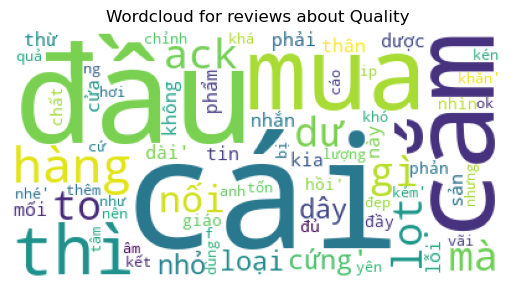

In [21]:
generate_wordcloud_by_label("Quality")

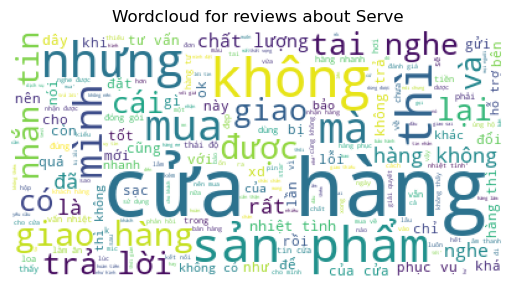

In [22]:
generate_wordcloud_by_label("Serve")

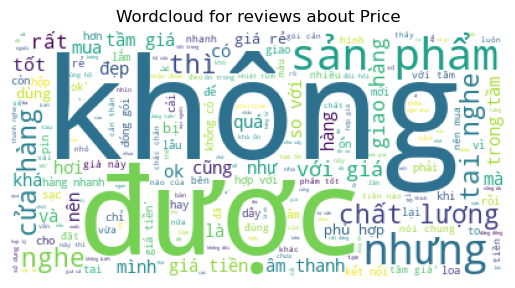

In [23]:
generate_wordcloud_by_label("Price")

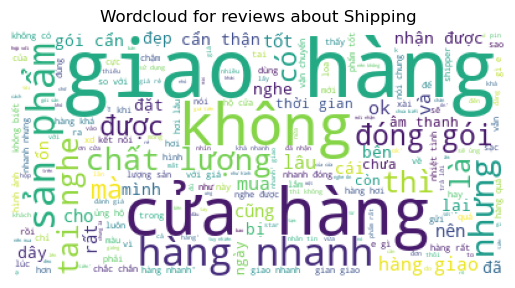

In [24]:
generate_wordcloud_by_label("Shipping")

# 3. Modelling 

In [25]:
df

,index,Unnamed: 0,rating_star,comment,Quality,Serve,Price,Pack,Shipping
0,0,0.0,2,dây cứng,1,0,0,0,0
1,1,1.0,2,gì ack cắm mua cái loại mà đầu to đầu nhỏ p...,1,0,0,0,0
2,2,2.0,2,sản phẩm lỗi nhắn tin cửa hàng không phản hồi,1,1,0,0,0
3,3,3.0,2,phần lắp bị xước nhắn tin chất với cửa hàng th...,1,1,0,0,0
4,4,4.0,2,sau ngày dùng thửhàng gửi hộp giấy không đúng...,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
4764,1371,0.0,5,cửa hàng phục vụ tốt tư vấn nhiệt tình rất th...,0,1,0,0,0
4765,1372,0.0,4,giáo hàng đầy đủ nhìn chất lượng nhưng chỉnh â...,1,0,0,0,1
4766,1373,0.0,5,hàng như quả ng cáo dùng ok anh cứ yên tâm mua...,1,0,0,0,0
4767,1374,0.0,5,đã nhận hàng dịch bệnh nhưng giao nhanh chưa t...,0,1,0,0,1


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

X_train, X_test, y_train, y_test = train_test_split(df["comment"], df["Serve"], test_size= 0.2, random_state= 60)

# baseline model
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 5), tokenizer=word_tokenize, stop_words=STOPWORDS,max_df=0.5, min_df=4)
def generate_feature(X):
    X_train1 = vectorizer.fit_transform(X)
#    X_train1 = TfidfTransformer().fit_transform(X_train1)
    return X_train1
X_train1 = vectorizer.fit_transform(X_train)
# X_train1 = TfidfTransformer().fit_transform(X_train1)

from catboost import CatBoostClassifier

cat = CatBoostClassifier()
cat.fit(X_train1, y_train, verbose=100)

c:\Users\DELL24H.VN\anaconda3\envs\vietnamNLP\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a', 'ai', 'alô', 'amen', 'anh', 'ba', 'ba ba', 'bao', 'bao giờ', 'bao lâu', 'bao nhiêu', 'bay', 'biến', 'biết', 'biết bao', 'biết bao nhiêu', 'biết đâu', 'buổi', 'bà', 'bài', 'bác', 'bán', 'bán dạ', 'bây', 'bây bẩy', 'bây giờ', 'bây nhiêu', 'bèn', 'béng', 'bên', 'bông', 'bước', 'bạn', 'bản', 'bản thân', 'bất', 'bất chợt', 'bất cứ', 'bất giác', 'bất kì', 'bất kể', 'bất kỳ', 'bất luận', 'bất ngờ', 'bất nhược', 'bất quá', 'bất thình', 'bất tử', 'bất ý', 'bất đồ', 'bấy', 'bấy chầy', 'bấy chừ', 'bấy giờ', 'bấy lâu', 'bấy lâu nay', 'bấy nay', 'bấy nhiêu', 'bập', 'bập bõm', 'bắt đầu', 'bằng', 'bển', 'bệt', 'bị', 'bỏ', 'bỗng', 'bỗng dưng', 'bỗng nhiên', 'bộ', 'bội', 'bớ', 'bởi', 'bởi thế', 'bởi vì', 'bởi vậy', 'bức', 'cao', 'cao ráo', 'cao thế', 'cha', 'chao', 'chi', 'chia s

Learning rate set to 0.018249
0:	learn: 0.6757914	total: 307ms	remaining: 5m 7s
100:	learn: 0.2532591	total: 6.01s	remaining: 53.5s
200:	learn: 0.2087300	total: 10.1s	remaining: 40.1s
300:	learn: 0.1886573	total: 13.7s	remaining: 31.9s
400:	learn: 0.1744285	total: 17.4s	remaining: 25.9s
500:	learn: 0.1636676	total: 20.7s	remaining: 20.6s
600:	learn: 0.1525055	total: 24s	remaining: 15.9s
700:	learn: 0.1410445	total: 28.8s	remaining: 12.3s
800:	learn: 0.1325640	total: 32.5s	remaining: 8.09s
900:	learn: 0.1246552	total: 36.1s	remaining: 3.96s
999:	learn: 0.1177926	total: 39.4s	remaining: 0us


In [27]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb = nb.fit(X_train1, y_train)
nb.score(X_train1, y_train)

0.9294888597640891

In [35]:
cat.score(X_train1, y_train)

0.964875491480996

In [28]:
# X_train represented
features = pd.DataFrame(X_train1.toarray(), columns = vectorizer.get_feature_names_out())
features

a  ack  ae  ah  ai  ai mua  ai ngờ  airpod  am thanh  and  anh  anh em  \
0     0    0   0   0   0       0       0       0         0    0    0       0   
1     0    0   0   0   0       0       0       0         0    0    0       0   
2     0    0   0   0   0       0       0       0         0    0    0       0   
3     0    0   0   0   0       0       0       0         0    0    0       0   
4     0    0   0   0   0       0       0       0         0    0    0       0   
...  ..  ...  ..  ..  ..     ...     ...     ...       ...  ...  ...     ...   
3810  0    0   0   0   0       0       0       0         0    0    0       0   
3811  0    0   0   0   0       0       0       0         0    0    0       0   
3812  0    0   0   0   0       0       0       0         0    0    0       0   
3813  0    0   0   0   0       0       0       0         0    0    0       0   
3814  0    0   0   0   0       0       0       0         0    0    0       0   

      ap  arm  b  ba  ban đầu  band  bao  bao giờ  bao lâu  bao nhiêu  bas  \
0      0    0  0   0        0     0    0        0        0          0    0   
1      0    0  0   0        0     0    0        0        0          0    0   
2      0    0  0   0        0     0    0        0        0          0    0   
3      0    0  0   0        0     0    0        0        0          0    0   
4      0    0  0   0        0     0    0        0        0          0    0   
...   ..  ... ..  ..      ...   ...  ...      ...      ...        ...  ...   
3810   0    0  0   0        0     0    0        0        0          0    0   
3811   0    0  0   0        0     0    0        0        0          0    0   
3812   0    0  0   0        0     0    0        0        0          0    0   
3813   0    0  0   0        0     0    0        0        0          0    0   
3814   0    0  0   0        0     0    0        0        0          0    0   

      bas hơi  bay  bin  biết  biết bền  biết bền không  biết chất lượng  \
0           0    0    0     0         0               0                0   
1           0    0    0     0         0               0                0   
2           0    0    0     0         0               0                0   
3           0    0    0     0         0               0                0   
4           0    0    0     0         0               0                0   
...       ...  ...  ...   ...       ...             ...              ...   
3810        0    0    0     0         0               0                0   
3811        0    0    0     0         0               0                0   
3812        0    0    0     0         0               0                0   
3813        0    0    0     0         0               0                0   
3814        0    0    0     0         0               0                0   

      biết chất lượng ra  biết chất lượng ra sao  biết có  biết có bền  \
0                      0                       0        0            0   
1                      0                       0        0            0   
2                      0                       0        0            0   
3                      0                       0        0            0   
4                      0                       0        0            0   
...                  ...                     ...      ...          ...   
3810                   0                       0        0            0   
3811                   0                       0        0            0   
3812                   0                       0        0            0   
3813                   0                       0        0            0   
3814                   0                       0        0            0   

      biết có bền không  biết cửa hàng  biết là  biết nhưng  biết sao  \
0                     0              0        0           0         0   
1                     0              0        0           0         0   
2                     0              0        0           0         0   
3             

In [36]:
X_test1 = vectorizer.transform(X_test)
# X_test1 = TfidfTransformer().fit_transform(X_test1)
cat.score(X_test1, y_test)

0.9203354297693921

In [37]:
nb.score(X_test1, y_test)

0.8857442348008385

# 3. Evaluation

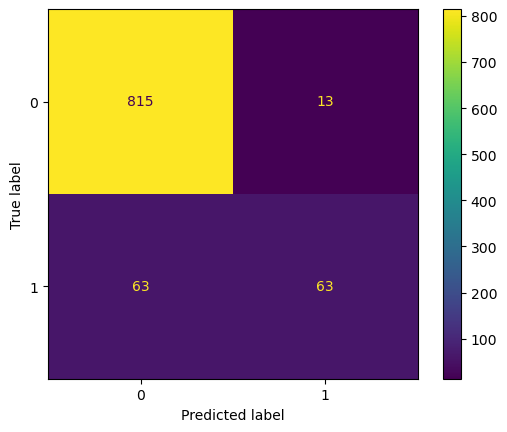

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, cat.predict(X_test1)))
disp.plot()
plt.show()

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test, cat.predict(X_test1)))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       828
           1       0.83      0.50      0.62       126

    accuracy                           0.92       954
   macro avg       0.88      0.74      0.79       954
weighted avg       0.92      0.92      0.91       954



In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test, nb.predict(X_test1)))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       828
           1       0.56      0.63      0.59       126

    accuracy                           0.89       954
   macro avg       0.75      0.78      0.76       954
weighted avg       0.89      0.89      0.89       954



In [39]:
# kiểm tra xem có nhãn thiếu
pd.set_option("max_colwidth", None)
X = vectorizer.transform(df["comment"])
df[(df["Serve"] == 0) & (cat.predict(X) == 1)]

,index,Unnamed: 0,rating_star,comment,Quality,Serve,Price,Pack,Shipping
377,377,394.0,2,đặt dây dù tròn mà giao dây này chán cửa hàng,0,0,0,0,1
663,663,695.0,2,inbox cửa hàng không thèm trả lời giao hàng khác nhưng không nói một câu,1,0,0,0,0
810,810,851.0,2,đặt màu đen giao tới màu trắng cửa hàng làm ăn gì kì cục vậy,0,0,0,0,1
884,884,927.0,2,săn sale k giao khá nhanh vì cửa hàng ở hà nội nhưng đặt trắng để chung màu với airpod thì giao đen ủa là s,0,0,0,0,1
1115,161,0.0,1,cửa hàng làm ăn như con cặc vậy tai nghe sử dụng ngôn ngữ trung quốc hỏi cách thay đổi lai ngon ngữ lại bảo sản phẩm không đổi dược đéo hiểu kiểu gì,1,0,0,0,0
1177,223,0.0,1,không nên mua đồng hồ ở đây nhé gh thì rất lâu đồng hồ bị trầy nhiều chất lượng phục vụ kém rất thất vọng khi mua chiếc đồng hồ quá là dởm như thế này negative negative đừng bao h mua đồng hồ của cửa hàng này nha mọi người,1,0,0,0,0
1295,341,0.0,1,tệ cực kỳ tệ cửa hàng phục vụ khách kém sẽ không có lần sau,1,0,0,0,0
1609,655,0.0,1,đừng mua nhé mọi ngườimình có đọc bình luận là chỉ nghe được bên mà mình bỏ qua vẫn mua và đúng là chỉ nghe được bên xd có nhắn tin cho cửa hàng và làm theo rất nhìu yêu cầu của cửa hàng nhưng thực sự là do sản phẩm bị lỗivà vẫn không nhận được hỗ trợ về sản phẩm,1,0,0,0,0
1897,943,0.0,1,mình mua sản phẩm flash sale k của cửa hàng cửa hàng biết mình mua nhiều sản phẩm giá rẻ sẽ không trả hànghoàn tiền nên cố tình không giao đúng hàng đặt loại tai nghe nhưng nhận về chỉ loại hỏi lại thì cửa hàng bảo hết hàng nên giao loại khác giao loại khác mà không hỏi khách có đồng ý nhận hay không,1,0,0,0,0
2089,1135,0.0,1,rất không đáng tiền bỉ thêm ít qua cửa hàng khác mua còn hơn nản mới mua tưởng pin bị lỗi cửa hàng kêu sạc lại sạc lại xong lên dược sạc dược xíu còn rồi luôn nhắn tin cửa hàng xong im không lẽ bỏ luôn cuối năm mà xui đủ thứ giao hàng thì cả tuần hơn mới giao được nhưng dịch nên không đánh giá phần vận chuyển,1,0,0,0,0


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

###prepare models
models = []
models.append(('LR',LogisticRegression()))
models.append(('DT',DecisionTreeClassifier()))
models.append(('NB',BernoulliNB()))
models.append(('RF',RandomForestClassifier()))
models.append(('CAT',CatBoostClassifier(verbose=200)))
###evaluate each model
results = []
names = []
scoring = 'roc_auc'
for name, model in models:
    kfold = KFold(n_splits=5,random_state = 99,shuffle=True)
    cv_results = cross_val_score(model, X_train1,y_train,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

LR: 0.737163 (0.027722)
DT: 0.589390 (0.028821)
NB: 0.661466 (0.025589)


KeyboardInterrupt: 